In [1]:
import utils.dataset_functions as df
import utils.two_towers as ttn
import utils.metrics as mt
import torch
import numpy as np
from pathlib import Path
import pandas as pd
import random
 
# df path
save_path = Path("results")
save_path.mkdir(parents=True, exist_ok=True)
song_embeds = Path("dataset") / "processed" / "song_subset.pt"

# Dimensions of the tower FFN
output_dim      = 16
hidden_dim      = 256
id_dim          = 16

# Load user data
user_item_data = pd.read_csv(Path("dataset") / "processed" / "merged.csv", index_col=False)

# Song embeddings
unique_songs = user_item_data[['item_id', 'normalized_embed']].drop_duplicates()
unique_songs["normalized_embed"] = unique_songs["normalized_embed"].apply(df.parse_embedding)

# User interactions
likes = pd.read_csv(Path("dataset") / "processed" / "likes.csv", usecols=['uid', 'timestamp', 'item_id']).drop_duplicates()
dislikes = pd.read_csv(Path("dataset") / "processed" / "dislikes.csv", usecols=['uid', 'timestamp', 'item_id']).drop_duplicates()


# Load our models
binary_model = ttn.DualAugmentedTwoTower("binary_label", hidden_dim, output_dim, id_dim)
binary_model.load(Path("models")/ "binary_label.pt")
non_binary_model = ttn.DualAugmentedTwoTower("continueous_label", hidden_dim, output_dim, id_dim)
non_binary_model.load(Path("models")/ "continueous_label.pt")

# Load test set:
samples = df.load_tensor_dataloader("test", Path("dataset")/"processed", 1, label_id=2)

# Songs is a pre-computed forward pass on all the songs for both 'binary' and 'continueous' models.
if song_embeds.exists():
    songs = torch.load(song_embeds, weights_only=False)  
else:
    songs = df.song_embeddings_pass_file(unique_songs, binary_model, non_binary_model)

binary_embeddings = songs['binary']
non_binary_embeddings = songs['continueous']

In [2]:
non_binary_embeddings

{0: tensor([0.0000, 0.4837, 0.0000, 0.8307, 0.2755, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000]),
 1: tensor([ 0.0000,  0.6032,  0.0000,  0.6993,  0.3836,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.1799,  0.2314, -0.3802,  0.0303,  0.0719, -0.2376,  0.0426,  0.0478,
          0.1627, -0.0769,  0.0549,  0.0955, -0.0944, -0.0858, -0.0379,  0.0501]),
 2: tensor([ 0.0000,  0.3054,  0.0000,  0.9417,  0.1414,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.2677, -1.3560, -1.1280, -0.9298, -0.5629,  0.4438,  0.9080,  0.1487,
          0.5851,  0.7144, -0.2443,  0.7192, -0.2962,  1.2287, -0.0224, -0.9427]),
 3: tensor([ 0.0000,  0.4928,  0.0000,  0.817

In [3]:
# Create the index for all song embeddings
non_binary_index = np.array([i.tolist() for i in non_binary_embeddings.values()])
binary_index = np.array([i.tolist() for i in binary_embeddings.values()])

non_binary_model.create_index(non_binary_index)
binary_model.create_index(binary_index)

In [4]:
uids = []
interactions = []

user_item_data.groupby('uid')
likes.groupby('uid')
dislikes.groupby('uid')

for user in user_item_data['uid'].unique():

    uidata_subset = user_item_data[user_item_data['uid'] == user]

    likes_subset = likes[(likes['uid'] == user) & (likes['item_id'].isin(uidata_subset['item_id'].unique()))]
    dislikes_subset = dislikes[(dislikes['uid'] == user) & (dislikes['item_id'].isin(uidata_subset['item_id'].unique()))]

    ints = (len(likes_subset) + len(dislikes_subset))/ len(uidata_subset)
    uids.append(user)
    interactions.append(ints)

interaction_ratio = pd.DataFrame({'uid' : uids, 'ratio': interactions}).sort_values('ratio', ascending=False)
interaction_ratio

,uid,ratio
1276,1276,0.800000
1247,1247,0.672340
2812,2812,0.580645
1249,1249,0.569061
77,77,0.522556
...,...,...
3994,3994,0.000000
3993,3993,0.000000
3992,3992,0.000000
1558,1558,0.000000


In [5]:
num_users = 100

selected_users = interaction_ratio[:num_users]['uid'].to_list()
duplicates = 0
users = {}
for user_features, song_embedding, label, interaction, user_id, song_id in samples.dataset:
    if user_id.item() in selected_users:
        if users.get(user_id.item()) is None:
            users[user_id.item()] = {}
            users[user_id.item()]['user_embed_bin'] = binary_model.user_pass(user_features.unsqueeze(0), user_id.unsqueeze(0)).detach().squeeze(0)
            users[user_id.item()]['user_embed_nbin'] = non_binary_model.user_pass(user_features.unsqueeze(0), user_id.unsqueeze(0)).detach().squeeze(0)
            users[user_id.item()]['song_data'] = {song_id.item(): (label.squeeze(0).tolist(), interaction.item())}

        
        else:
            if users[user_id.item()]['song_data'].get(song_id.item()) is not None:
                duplicates += 1
            users[user_id.item()]['song_data'][song_id.item()] = (label.squeeze(0).tolist(), interaction.item())


duplicates

4767

In [18]:
# Now, for each user we make a recommendation of size 'num_rec'. And we score these recommendations using the dot product.

# If a song from the recommendation was ALSO in our test set, we overwrite the base label and interection, 
# which was set at -1 and 0 resprectively as that indicates whether this user has any history with the recommended song.   


# Number of recommendations to make
num_rec = 1000

total_users = []
total_nbin_song_ids = []
total_nbin_distances = []
total_nbin_score = []
total_nbin_labels = []
total_nbin_interactions = []

total_bin_song_ids = []
total_bin_distances = []
total_bin_score = []
total_bin_labels = []
total_bin_interactions = []



for u in users.keys():

    user = users[u]

    # 1. Make binary and non-binary recommendations.
    nbin_query = user["user_embed_nbin"][np.newaxis, :]
    nbin_distances, nbin_indices = non_binary_model.recommendations(nbin_query, num_rec)

    bin_query = user["user_embed_bin"][np.newaxis, :]
    bin_distances, bin_indices = binary_model.recommendations(bin_query, num_rec)

    
    # 2. Score them and init the label and interaction lists
    nbin_score  = [(nbin_query * non_binary_embeddings[e]).sum().item() for e in nbin_indices]
    nbin_labels = [-1 for _ in range(num_rec)]
    nbin_interactions = [0 for _ in range(num_rec)]

 
    bin_score = [(bin_query * binary_embeddings[e]).sum().item() for e in bin_indices]
    bin_labels = [-1 for _ in range(num_rec)]
    bin_interactions = [0 for _ in range(num_rec)]

   

    
    # 3. Now for both binary and non_binary, check whether each song_id check if it has been listened to before in the test set and overwrite the label and interaction with actual values.
    for i in range(len(nbin_indices)):
        song_id = nbin_indices[i]
        song_data = user["song_data"].get(song_id) 
        
        if song_data is not None:
            nbin_labels[i] = song_data[0][1]
            nbin_interactions[i] = song_data[1]

    
    for i in range(len(bin_indices)):
        song_id = bin_indices[i]
        song_data = user["song_data"].get(song_id) 
        if song_data is not None:
            bin_labels[i] = song_data[0][0]
            bin_interactions[i] = song_data[1]






    # Add the total together for our dataframes
    total_users += [u for _ in range(len(bin_indices))]
    total_nbin_song_ids += nbin_indices
    total_nbin_distances += nbin_distances
    total_nbin_score += nbin_score
    total_nbin_labels += nbin_labels
    total_nbin_interactions += nbin_interactions

    total_bin_song_ids += bin_indices
    total_bin_distances += bin_distances
    total_bin_score += bin_score
    total_bin_labels += bin_labels
    total_bin_interactions += bin_interactions
    

In [19]:
bin_df = pd.DataFrame(
            data = {"uid": total_users,
                    "song_id": total_bin_song_ids,
                    "distances": total_bin_distances,
                    "score": total_bin_score,
                    "label": total_bin_labels,
                    "interaction": total_bin_interactions
            })

dic = bin_df['label'].value_counts().to_dict()

# met train filter:     -1 count = 99%
# zonder train filter:  -1 count = 96%

# Met 25 rec:
# met train filter:     -1 count = 99%
# zonder train filter:  -1 count = 95%

total = 0
labels = 0

for l, c in dic.items():
    total += c
    if l != -1:
        labels += c 


labels/total 

0.02198076923076923

In [ ]:
bin_df[(bin_df['label'] != -1)& (bin_df['uid'] == 1849)]

,uid,song_id,distances,score,label,interaction
0,1849,1318,14.052412,3.480685,-1.0,0
1,1849,2395,14.644291,4.222259,-1.0,0
2,1849,1790,14.662007,2.941763,-1.0,0
3,1849,2345,14.925432,3.934561,-1.0,0
4,1849,1717,14.980394,2.626756,-1.0,0
...,...,...,...,...,...,...
995,1849,220,19.057491,0.256417,-1.0,0
996,1849,1106,19.057833,0.339906,-1.0,0
997,1849,1003,19.058247,0.245644,-1.0,0
998,1849,1729,19.060146,0.300853,-1.0,0


In [9]:
bin_df[bin_df['uid']== 1849].sort_values('score', ascending=False)

,uid,song_id,distances,score,label,interaction
12,1849,1897,15.728760,4.607982,-1.0,0
1,1849,2395,14.644291,4.222259,-1.0,0
31,1849,2927,16.372566,3.973481,-1.0,0
3,1849,2345,14.925432,3.934561,-1.0,0
0,1849,1318,14.052412,3.480685,-1.0,0
...,...,...,...,...,...,...
366,1849,1209,18.194975,0.702437,-1.0,0
393,1849,411,18.248999,0.695700,-1.0,0
398,1849,967,18.256187,0.686178,-1.0,0
392,1849,1517,18.242725,0.671165,-1.0,0


In [10]:
nbin_df = pd.DataFrame(
            data = {"uid": total_users,
                    "song_id": total_nbin_song_ids,
                    "distances": total_nbin_distances,
                    "score": total_nbin_score,
                    "label": total_nbin_labels,
                    "interaction": total_nbin_interactions
            })

dic = nbin_df['label'].value_counts().to_dict()

# met train filter:     -1 count = 99%
# zonder train filter:  -1 count = 95%

# Met 25 rec:
# met train filter:     -1 count = 99%
# zonder train filter:  -1 count = 95%

total = 0
labels = 0

for l, c in dic.items():
    total += c
    if l != -1:
        labels += c 


labels/total 

0.019759615384615386

In [11]:
nbin_df

,uid,song_id,distances,score,label,interaction
0,1849,3111,4.724811,2.109613,-1.0,0
1,1849,1790,4.778694,2.670400,-1.0,0
2,1849,1791,4.791964,3.031308,-1.0,0
3,1849,102,4.815561,3.555545,-1.0,0
4,1849,3080,4.927236,2.776523,-1.0,0
...,...,...,...,...,...,...
20795,1979,622,10.793886,1.277628,-1.0,0
20796,1979,777,10.797945,1.654711,-1.0,0
20797,1979,1926,10.798729,1.736875,-1.0,0
20798,1979,1585,10.800507,1.342135,-1.0,0


In [12]:
# Save our df's
bin_df.to_csv(save_path / "bin_df.csv", index=False)
nbin_df.to_csv(save_path/ "nbin_df.csv", index=False)

In [13]:
import utils.dataset_functions as df
import utils.two_towers as ttn
import utils.metrics as mt
import torch
import numpy as np
from pathlib import Path
import pandas as pd

# df path
save_path = Path("results")
save_path.mkdir(parents=True, exist_ok=True)

# Dimensions of the tower FFN
output_dim      = 16
hidden_dim      = 256
id_dim          = 16


device='cuda' if torch.cuda.is_available() else 'cpu'
print("Training models on:", device)

# Load our df's like so:
bin_df = pd.read_csv(save_path / "bin_df.csv", index_col=False)
nbin_df= pd.read_csv(save_path/ "nbin_df.csv", index_col=False)

Training models on: cuda


In [14]:
bin_rankings = []
nbin_rankings = []
for u in bin_df['uid'].unique():
    temp = bin_df[bin_df['uid'] == u].sort_values('score', ascending=False)
    if temp['interaction'].sum() > 0:
        bin_rankings.append(temp['label'].to_list())

for u in nbin_df['uid'].unique():
    temp = nbin_df[nbin_df['uid'] == u].sort_values('score', ascending=False)
    if temp['interaction'].sum() > 0:
        nbin_rankings.append(temp['label'].to_list())


In [15]:
bin_rankings = np.array(bin_rankings)
nbin_rankings = np.array(nbin_rankings)
bin_scores = []
for val in bin_rankings:
    bin_scores.append(mt.metrics(val, [20]))
    
nbin_scores = []
for val in nbin_rankings:
    nbin_scores.append(mt.metrics(val, [20]))
    
binary_scores = np.array(bin_scores)
non_binary_scores = np.array(nbin_scores)

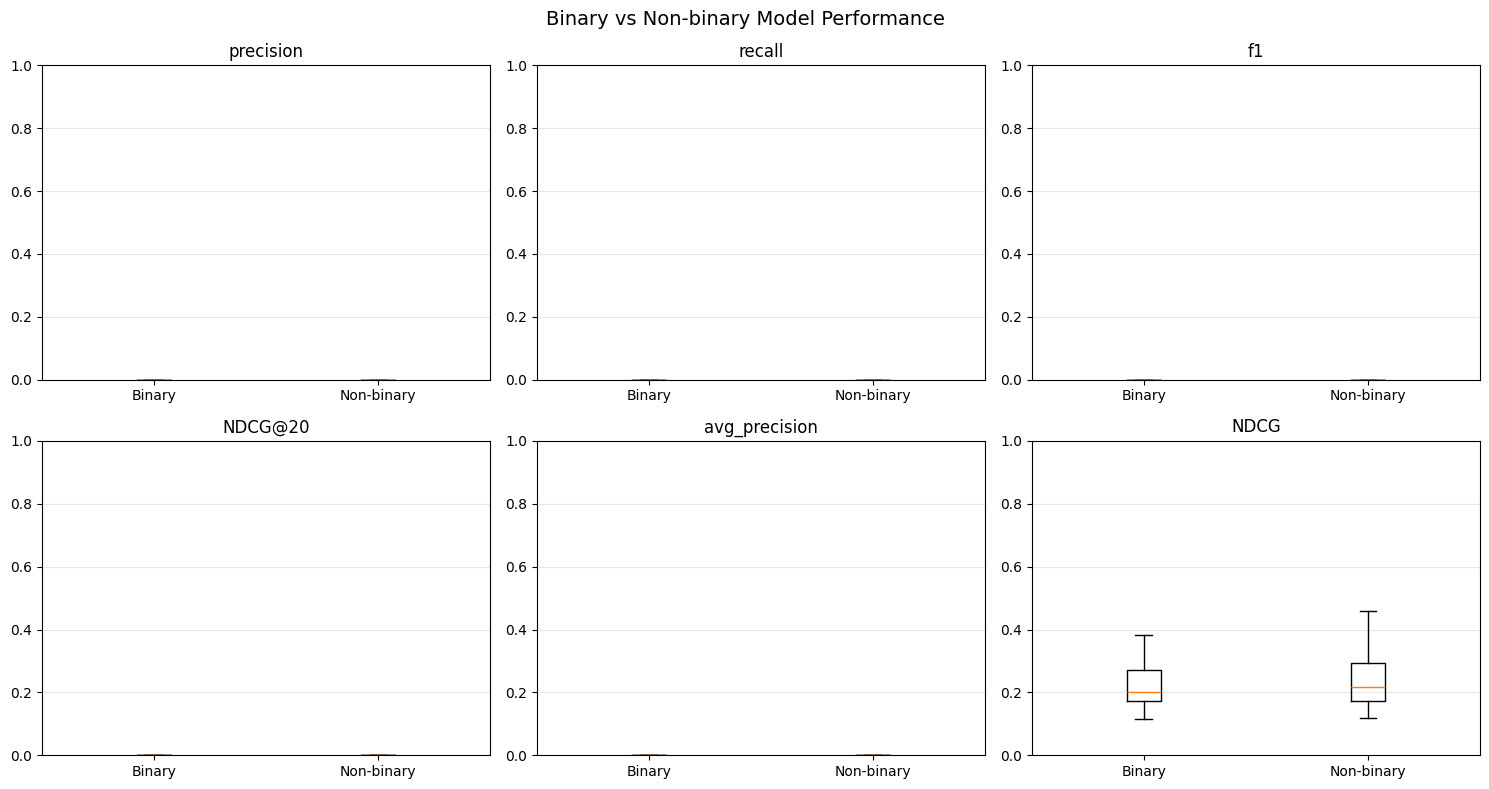

In [16]:
import matplotlib.pyplot as plt

metrics = ["precision", "recall", "f1", "NDCG@20", "avg_precision", "NDCG"]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.boxplot(
        [binary_scores[:, i], non_binary_scores[:, i]],
        tick_labels=["Binary", "Non-binary"],
        showfliers=False
    )

    ax.set_title(metrics[i])
    ax.set_ylim(0, 1)
    ax.grid(axis="y", alpha=0.3)

fig.suptitle("Binary vs Non-binary Model Performance", fontsize=14)
plt.tight_layout()
plt.show()
